In [2]:
import os 
import numpy as np 
import pandas as pd
from scipy.special import softmax 
import pingouin as pg 

%matplotlib inline
%config InlineBackend.figure_format='retina'

import matplotlib.pyplot as plt 
import seaborn as sns 

#from utils.env import frozen_lake
import sys
sys.path.append('..')
from utils.viz import viz
from utils.model import *
from utils.fig_fn import *
viz.get_style()

## Set size effect for all models

In [3]:
def get_asymptote_acc(data):
    asymptote = {'block_type': [], 'acc': [], 'sub_id': []}
    for sub_id in data['sub_id'].unique():
        sub_data = data.query(f'sub_id=="{sub_id}"').reset_index(drop=True)
        block_lst = sub_data['block_id'].unique()
        for block_id in block_lst:
            block_data = sub_data.query(f'block_id=={block_id}').reset_index(drop=True)
            max_rep = block_data['repetitions'].max().astype(int)
            reps = list(range(max_rep, max_rep+1))
            sel_data = block_data.query(f'repetitions in {reps}')
            set_size = sel_data['block_type'].unique()[0].astype(int)
            acc = sel_data['r'].mean()
            asymptote['sub_id'].append(sub_id)
            asymptote['block_type'].append(set_size)
            asymptote['acc'].append(acc)
    asymptote = pd.DataFrame(asymptote)
    sel_data = asymptote.groupby(by=['block_type', 'sub_id']
            ).agg({'acc': 'mean'}).reset_index()
    return sel_data

def two_behavioral_patterns(data, axs, mode='human'):
    data = data.copy()
    if mode!='model': data['r'] = data['acc']
    sel_data = get_asymptote_acc(data)    # the set size effect
    ax = axs[0]
    sns.lineplot(x='repetitions', y='r', 
                    data=data.query(f'repetitions<10'), 
                    legend=False,
                    errorbar=('ci', 95), 
                    hue='block_type', lw=2.25, 
                    ax=ax)
    # add the optimal curve
    opt_curve = [1/3, 2/3] + [1]*7
    x = np.arange(1, 10)
    ax.plot(x, opt_curve, color=viz.Blue, lw=3, ls='--')
    ax.spines['left'].set_position(('axes',-0.05))
    ax.set_xticks([1, 3, 5, 7, 9])
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Repetitions')
    ax.set_box_aspect(.85)
    # the asymptote accuracy
    ax = axs[1]
    sns.barplot(sel_data, y='acc',
                x='block_type', order=[2, 3, 4, 5, 6],
                errorbar=('ci', 0), 
                palette = sns.cubehelix_palette(n_colors=5, as_cmap=False), hue='block_type',
                width=.7,
                legend=False,
                ax=ax)
    ax.spines['left'].set_position(('axes',-0.05))
    ax.set_ylim(.75, 1.05)
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Set size')
    ax.set_box_aspect(.85)

In [4]:
# simulation function 
def sim(env_fn, agent, params, n_sub=20, n_sim=20):
    model = wrapper(eval(agent), setsize_task)
    rng = np.random.RandomState(2025)
    params = eval(agent).link_params(params)
    sim_data = []
    seed = 2023
    for sub_id in range(n_sub):
        # creat data for each subject
        # for each block type
        sub_data = {}
        for i, block_type in enumerate(range(2, 7)):
            block_data = env_fn(block_type).instan(max_reps=50, seed=seed+i)
            block_data['block_id'] = i
            sub_data[i] = block_data
        for i in range(n_sim):
            sim_datum = model.sim(sub_data, params, rng)
            sim_datum['sub_id'] = f'sub-{sub_id}'
            sim_datum['sim_id'] = f'sim-{i}'
            sim_data.append(sim_datum)
    # concat all the data
    sim_data = pd.concat(sim_data)
    return sim_data

In [5]:
params_dict = {
    'CURL': [20, 0], 
    'CCRL': [20, .95, 0], 
    'ecPG': [.75, 20, .1, .95]
}
beh_data = {}
for agent in params_dict.keys():
    params = params_dict[agent]
    beh_datum = sim(setsize_task, agent, params, n_sub=10, n_sim=40)
    beh_data[agent] = beh_datum

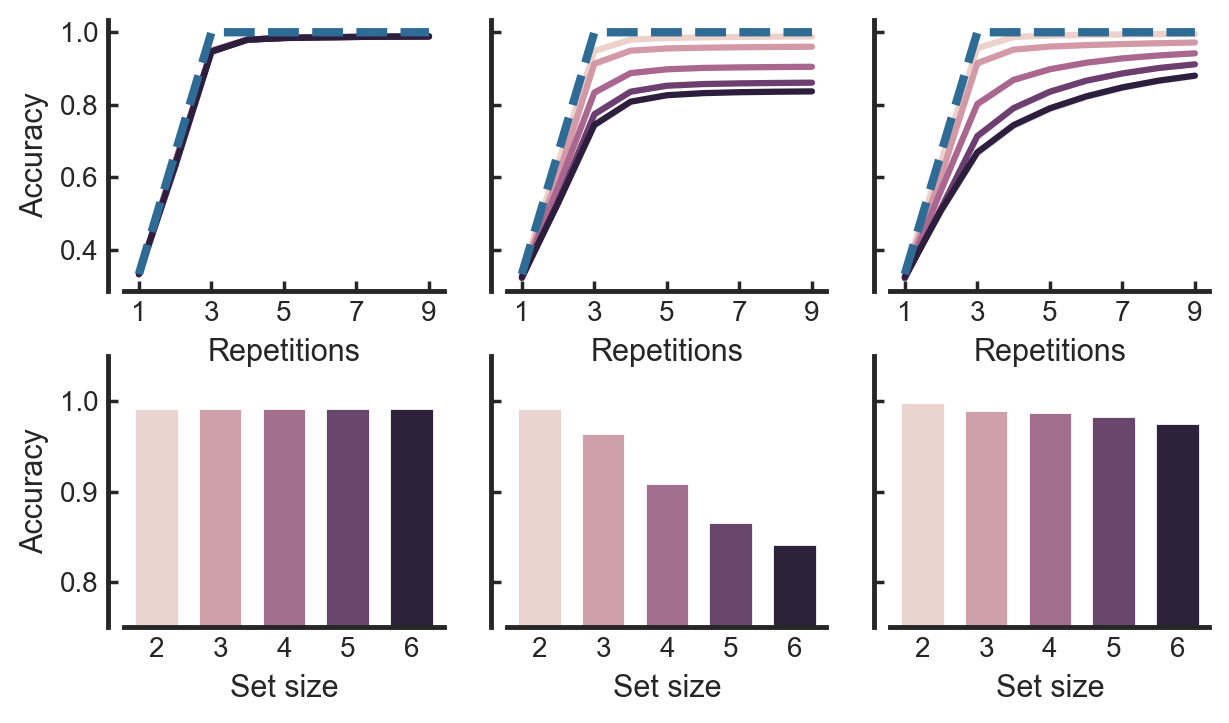

In [6]:
fig, axs = plt.subplots(2, 3, figsize=(7, 4), sharey='row')
for i, agent in enumerate(params_dict.keys()):
    two_behavioral_patterns(beh_data[agent], [axs[0,i], axs[1,i]])
    if i>0:
        axs[0,i].set_ylabel('')
        axs[1,i].set_ylabel('')
plt.savefig('../figures/Fig2/sim_setsize.pdf', dpi=300)

## The internal representation of set size

In [18]:
# simulation function 
def sim_data(data_set, agent, params):
    fname = f'../data/{data_set}.pkl'
    with open(fname, 'rb') as f: data = pickle.load(f)
    model = wrapper(eval(agent), setsize_task)
    sub_lst = data.keys()
    rng = np.random.RandomState(2025)
    params = eval(agent).link_params(params)
    sim_data = []
    for sub_id in sub_lst:
        sub_data = data[sub_id]
        sim_datum = model.sim(sub_data, params, rng)
        sim_data.append(sim_datum)
    sim_data = pd.concat(sim_data)
    return sim_data

In [45]:
agent = ecPG
env_fn = setsize_task
rparams = [1, 30, .1, .95, 0]

In [46]:
fname = '../data/setsize-collins12.pkl'
with open(fname, 'rb') as f: data = pickle.load(f)
# randomly pickle a set size = 6
np.random.seed(2024)
sub_lst = data.keys()
for sub_id in sub_lst:
    block_lst = data[sub_id].keys()
    for block in block_lst:
        task = data[sub_id][block]
        block_type = task['block_type'].unique()
        accept = np.random.rand()<0.5
        if block_type==6 and accept:
            tar_task = task 
            break
    break
    
rng = np.random.RandomState(2022)
params = agent.link_params(rparams)
n_sim = 100
sim_data = {}
for i in range(n_sim):     
    model = wrapper(agent, env_fn)
    insights = agent.insights
    sub_data = data[sub_id]
    model.register_hooks(*insights)
    sim_datum = model.sim_block(tar_task, params, rng)
    sim_data[i] = sim_datum

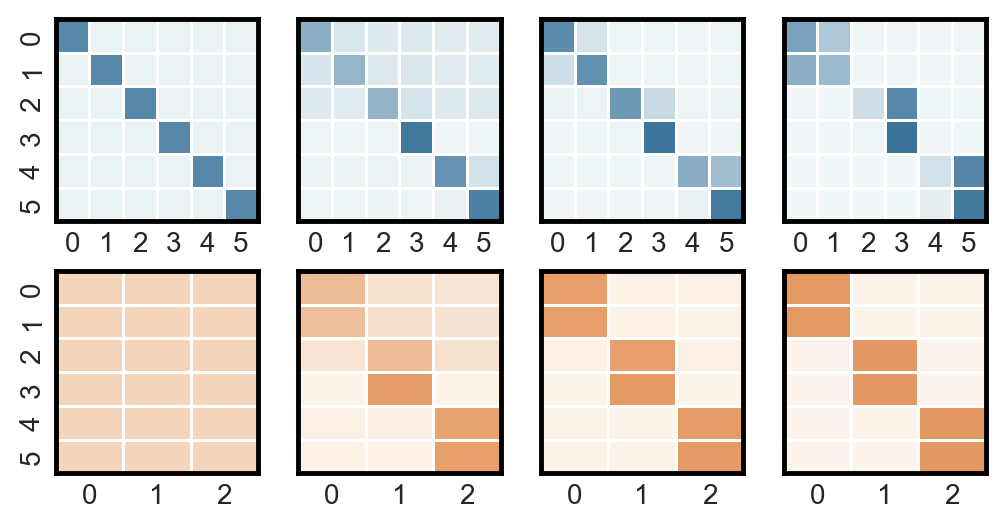

In [47]:
fig, axs = plt.subplots(2, 4, figsize=(6, 3), sharey=True)
trials = [0, 20, 40, 80]
for i, t in enumerate(trials):
    ax = axs[0, i]
    sns.heatmap(model.insights['enc'][t], ax=ax, 
                cbar=False,
                lw=.5, cmap=viz.BluesMap, vmin=0, vmax=1)
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color('black')
    ax.set_box_aspect(1)
    
    ax = axs[1, i]
    sns.heatmap(model.insights['pol'][t], ax=ax, 
                cbar=False,
                lw=.5, cmap=viz.YellowsMap, vmin=0, vmax=1)
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color('black')
    ax.set_box_aspect(1)
#plt.savefig('../figures/Fig2/enc_pol.pdf', dpi=300)
plt.show()

In [63]:
# get the correct answer 
cor_mapping = tar_task.groupby('s')['cor_a'].mean().reset_index()
cor_mat = []
for  s in np.arange(6):
    idx = cor_mapping.query(f's=={s}')['cor_a'].values.astype(int)
    cor_mat.append(np.eye(3)[idx])
U = np.vstack(cor_mat)

In [72]:
## calculate theoretical reward 
def get_theoretical_rew_BA(p_z1s, U, beta=100):
    nS, nZ = p_z1s.shape
    nA = U.shape[1]
    p_s = np.ones([nS, 1]) / nS
    p_z = p_z1s.T @ p_s # ZxS, Sx1 -> Zx1
    p_s1z = p_z1s * p_z.T # SxZ * 1xZ -> SxZ
    p_s1z = p_s1z / p_s1z.sum(1, keepdims=True) # SxZ
    p_a1z = np.ones([nZ, nA]) / nA
    p_a = p_a1z.T @ p_z # A x Z, Z x 1 -> A x 1
    # find the best decoder under a specfic
    # encoder using the balhut algorithm
    rew0 = 0
    while True: 
        # acccording to Genewein, 2016
        logit = beta*p_s1z.T@U + np.log(p_a.T) # ZxA + 1xA -> ZxA
        p_a1z = softmax(logit, axis=1) # ZxA
        p_a = p_a1z.T @ p_z # A x Z, Z x 1 -> A x 1
        rew = ((p_z1s@p_a1z) * U).sum(1).mean() # SxZ@ZxA * SxA -> SxZ
        # check convergence
        if np.abs(rew-rew0) < 1e-4:
            break
        rew0 = rew
    return rew

In [73]:
# get a list of encoder sequeneces
theta0 = theta_given_C(.95, 6)
p_z1s0 = softmax(theta0*np.eye(6), axis=1)
enc_seq = [p_z1s0] + model.insights['enc']
rew_seq = []
for p_z1s in enc_seq:
    rew = get_theoretical_rew_BA(p_z1s, U)
    rew_seq.append(rew)

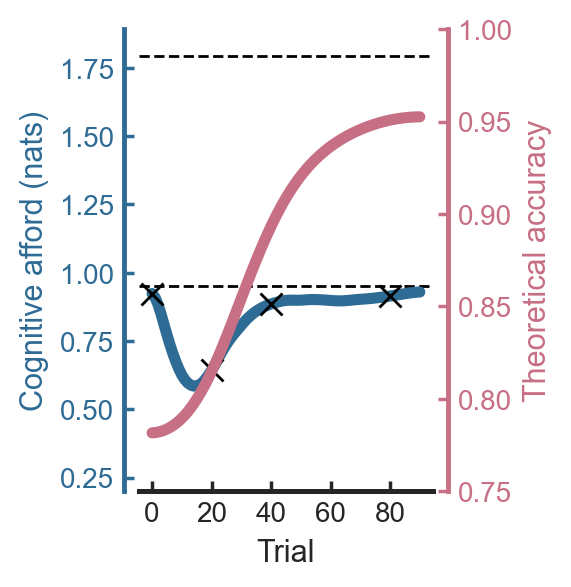

In [134]:
# average over all simulations 
i_sz = 0 
for i in range(n_sim):
    i_sz += sim_data[i]['i_SZ'].values / n_sim 
sz_data = {'i_SZ': [.95]+list(i_sz), 'trial': [0]+list(range(1, 91))}
from scipy.ndimage import gaussian_filter1d
i_sz = gaussian_filter1d(sz_data['i_SZ'], sigma=2)
rew_seq = gaussian_filter1d(rew_seq, sigma=2)
# Apply Gaussian smoothing to the learning curve
sz_data = {'i_SZ': i_sz, 'trial': list(range(91)), 'theoretical_rew': rew_seq}

sz_data = pd.DataFrame(sz_data)
fig, ax = plt.subplots(1, 1, figsize=(1.9, 3))
# the representation complexity 
color1 = viz.Blue
sns.lineplot(x='trial', y='i_SZ', data=sz_data, 
             color = color1, lw=4, ax=ax,
             zorder=100)
ax.axhline(y=.95, xmin=0, xmax=1, color='black', linestyle='--', lw=1)
ax.axhline(y=np.log(6), xmin=0, xmax=1, color='black', linestyle='--', lw=1)
ax.set_ylim(.2, np.log(6)+.1)
ax.yaxis.label.set_color(color1)
ax.spines['left'].set_position(('axes',-0.05))
ax.spines['left'].set_color(color1)
if np.any(ax.get_yticklabels()): ax.tick_params(axis='y', colors=color1)
ax.set_xticks([0, 20, 40, 60, 80])
ax.set_ylabel('Cognitive afford (nats)')
ax.set_xlabel('Trial')
# the theoretical reward
ax2 = ax.twinx() 
color1 = viz.Red
sns.lineplot(x='trial', y='theoretical_rew', data=sz_data, 
             color = color1, lw=4, ax=ax2, zorder=1)
ax2.set_ylim(.2, np.log(6)+.1)
ax2.yaxis.label.set_color(color1)
ax2.spines['left'].set_visible(False)
ax2.spines['right'].set_visible(True)
ax2.spines['right'].set_position(('axes',1.05))
ax2.spines['right'].set_color(color1)
x_positions = [0, 20, 40, 80]
for x in x_positions:
    ax.plot(x, sz_data['i_SZ'][x], 'x', color='black', 
            markersize=8,
            zorder=1000000)  # Add marker 'x' at positions 0, 10, 20, 80
ax2.set_ylim([.75, 1.0])
if np.any(ax2.get_yticklabels()): ax2.tick_params(axis='y', colors=color1)
ax2.set_ylabel('Theoretical accuracy')

plt.savefig('../figures/Fig2/i_sz.pdf', dpi=300)
plt.show()
